In [ ]:
# Uninstall existing numpy, gensim, and pandas forcefully
!pip uninstall numpy gensim pandas -y

# Reinstall numpy first. Using --no-cache-dir can sometimes help prevent caching issues.
!pip install numpy --upgrade --no-deps --no-cache-dir

# Reinstall gensim. This should now use the newly installed numpy during its setup.
!pip install gensim --upgrade --no-cache-dir

# Reinstall pandas, ensuring it uses the newly installed numpy
!pip install pandas --upgrade --no-cache-dir

# After running these commands, **RESTART YOUR PYTHON KERNEL**
# Then, run your notebook cells from the beginning.

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 177.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 300.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 242.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [2]:
!pip3 install pyro-ppl

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
punctuation = set(string.punctuation)

# Define the preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [stemmer.stem(word) for word in tokens]  # Stem the words
    return tokens

def add_mask_column(df, column_name, length, new_column_name='masked_list'):
    def pad_and_create_mask(lst):
        # Truncate if list is longer than the specified length
        truncated = lst[:length]

        # Create mask: 1s for actual values, 0s for padding
        mask = [1] * len(truncated)
        padding_length = max(0, length - len(truncated))
        mask += [0] * padding_length

        # Pad list with 0s if shorter than desired length
        padded_lst = truncated + [0] * padding_length

        return padded_lst, mask

    # Apply padding and mask creation
    result = df[column_name].apply(pad_and_create_mask)
    df[column_name] = result.apply(lambda x: x[0])  # overwrite with padded/truncated list
    df[new_column_name] = result.apply(lambda x: x[1])  # add mask column
    return df

In [74]:
df = pd.read_csv("bbc-news-data.csv", sep='\t', encoding='utf-8')
df['content'] = df['content'].apply(preprocess_text)
dictionary = Dictionary(df['content'])
df['content_indexed'] = df['content'].apply(lambda tokens: dictionary.doc2idx(tokens))
df['content_length'] = df['content_indexed'].apply(len)
df = df[df['content_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'content_indexed', length=60, new_column_name="content_masked")


W = df["content_indexed"]
Mask = df["content_masked"]

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T



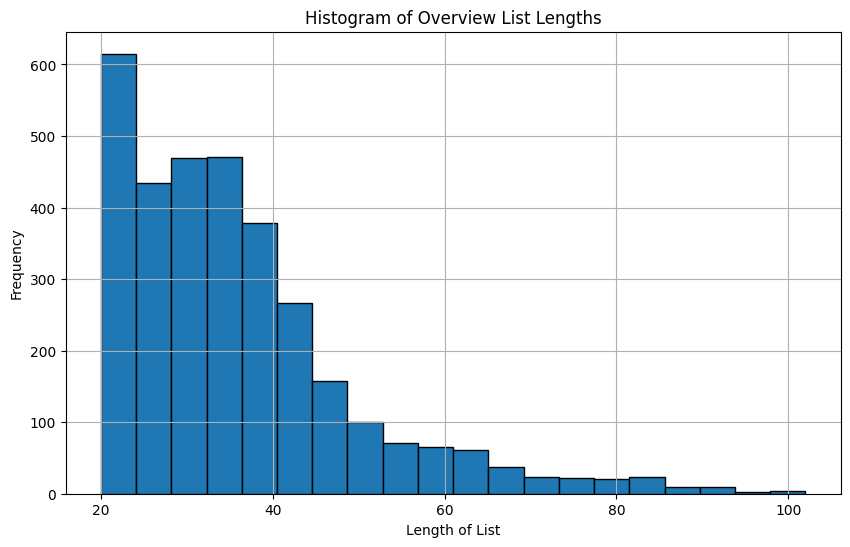

In [63]:
# Load the dataset
df = pd.read_csv("tmdb_5000_movies.csv")

# Remove rows with missing values in the 'overview' column
df.dropna(subset=['overview'], inplace=True)

# Apply to the DataFrame
df['processed'] = df['overview'].apply(preprocess_text)

# Create a dictionary and corpus for the processed text
dictionary = Dictionary(df['processed'])

# Map each list of tokens to a list of word indexes
df['overview_indexed'] = df['processed'].apply(lambda tokens: dictionary.doc2idx(tokens))

df['overview_length'] = df['overview_indexed'].apply(len)

df = df[df['overview_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'overview_indexed', length=60, new_column_name="overview_masked")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=20, edgecolor='black')
plt.title('Histogram of Overview List Lengths')
plt.xlabel('Length of List')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

W = df["overview_indexed"]
Mask = df["overview_masked"]
rating = df["vote_average"]
rating = rating.round().astype(int)
rating = torch.tensor(rating.values, dtype=torch.long)

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T


In [82]:
num_words = len(dictionary)
num_topics = 2
num_docs = W.shape[0]
num_words_per_doc = 60

In [83]:
def model(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"):
    """LDA model with masking for variable-length documents."""
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(0.1*torch.ones(num_words) / num_words)
        )
    
    # Ordinal regression parameters (priors)
    regression_coefs = None
    cutpoints = None

    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression.")

        # Priors for regression coefficients (one per topic)
        regression_coefs = pyro.sample(
            "regression_coefs",
            dist.Normal(torch.zeros(num_topics, device=device),
                        torch.ones(num_topics, device=device)).to_event(1)
        )

        # Priors for cutpoints (num_classes - 1 cutpoints, ordered)
        # c_0 ~ Normal
        # c_i = c_{i-1} + exp(delta_i), where delta_i ~ Normal for i > 0
        # This creates c_0 < c_1 < ... < c_{K-2}
        
        # Sample the first cutpoint
        c_0 = pyro.sample("c_0", 
                          dist.Normal(torch.tensor(0., device=device), 
                                      torch.tensor(5., device=device))) 
        
        if num_classes > 2: # If more than one cutpoint is needed (i.e., num_classes - 1 > 1)
            # Sample log differences for the remaining num_classes - 2 cutpoints
            # These correspond to log(c_1 - c_0), log(c_2 - c_1), ...
            log_diffs = pyro.sample(
                "log_diffs",
                dist.Normal(torch.zeros(num_classes - 2, device=device),
                            torch.ones(num_classes - 2, device=device)).to_event(1)
            )
            # Calculate cutpoints: c_0, c_0 + exp(log_diffs_0), c_0 + exp(log_diffs_0) + exp(log_diffs_1), ...
            # These are then c_0, c_1, c_2, ...
            incremental_cutpoints = c_0 + torch.cumsum(torch.exp(log_diffs), dim=-1)
            cutpoints = torch.cat([c_0.unsqueeze(0), incremental_cutpoints])
        elif num_classes == 2: # Exactly one cutpoint: c_0
            cutpoints = c_0.unsqueeze(0)
        # If num_classes == 1, an error was raised earlier. No cutpoints needed.


    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]  # data: [max_words, batch_size]
        if mask is not None:
            mask = mask[:, ind]  # same shape as data

        ratings_batch = None
        if ratings is not None: # ratings should be (num_docs,)
            ratings_batch = ratings[ind]
        
        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(0.1*torch.ones(num_topics) / num_topics)
        )
        
        # Ordinal regression part
        if ratings is not None and regression_coefs is not None and cutpoints is not None:
            # regression_coefs shape: (num_topics)
            # doc_topics shape: (batch_size, num_topics)
            # eta = (doc_topics * regression_coefs.unsqueeze(0)).sum(dim=-1)
            # Using matmul for clarity:
            eta = torch.matmul(doc_topics, regression_coefs) # (batch_size, num_topics) @ (num_topics) -> (batch_size)
            
            pyro.sample(
                "observed_ratings",
                dist.OrderedLogistic(predictor=eta, cutpoints=cutpoints, validate_args=True),
                obs=ratings_batch # ratings_batch should be (batch_size,) and contain integer classes 0..K-1
            )

        with pyro.plate("words", num_words_per_doc):
            with pyro.poutine.mask(mask=mask):
                word_topics = pyro.sample(
                    "word_topics", dist.Categorical(doc_topics),
                    infer={"enumerate": "parallel"}
                )

                doc_words = pyro.sample(
                    "doc_words",
                    dist.Categorical(topic_words[word_topics]),
                    obs=data
                )


    if ratings is not None:
        return topic_words, doc_words, regression_coefs, cutpoints
    else:
        return topic_words, doc_words

In [ ]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"): # Added ratings, num_classes, device
    # Guide for topic_words
    topic_words_posterior = pyro.param(
            "topic_words_posterior", # Kept original name
            lambda: torch.ones(num_topics, num_words, device=device), # Added device
            constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Guide for ordinal regression parameters (if model includes them)
    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified for guide if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression in guide.")

        # Guide for regression_coefs
        q_regr_coefs_loc = pyro.param(
            "q_regr_coefs_loc",
            lambda: torch.zeros(num_topics, device=device))
        q_regr_coefs_scale = pyro.param(
            "q_regr_coefs_scale",
            lambda: torch.ones(num_topics, device=device),
            constraint=constraints.positive)
        pyro.sample("regression_coefs",
                    dist.Normal(q_regr_coefs_loc, q_regr_coefs_scale).to_event(1))

        # Guide for c_0
        q_c0_loc = pyro.param(
            "q_c0_loc",
            lambda: torch.tensor(0.0, device=device))
        q_c0_scale = pyro.param(
            "q_c0_scale",
            lambda: torch.tensor(1.0, device=device),
            constraint=constraints.positive)
        pyro.sample("c_0", dist.Normal(q_c0_loc, q_c0_scale))

        if num_classes > 2:
            # Guide for log_diffs
            q_log_diffs_loc = pyro.param(
                "q_log_diffs_loc",
                lambda: torch.zeros(num_classes - 2, device=device))
            q_log_diffs_scale = pyro.param(
                "q_log_diffs_scale",
                lambda: torch.ones(num_classes - 2, device=device),
                constraint=constraints.positive)
            pyro.sample("log_diffs",
                        dist.Normal(q_log_diffs_loc, q_log_diffs_scale).to_event(1))

    # Guide for doc_topics
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior", # Kept original name
            lambda: torch.ones(num_docs, num_topics, device=device), # Added device
            constraint=constraints.positive) # Changed to positive for Dirichlet concentration

    with pyro.plate("documents", num_docs, batch_size) as ind:
        # Sample from a Dirichlet distribution for doc_topics
        pyro.sample("doc_topics", dist.Dirichlet(doc_topics_posterior[ind]))


if rating.min() > 0:
    print("Warning: Ratings are not 0-indexed. Consider adjusting them or num_classes calculation.")
num_classes_val = rating.max().item() + 1 if rating.numel() > 0 else 0

guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics']))) # We add the weights variables here
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)
torch.autograd.set_detect_anomaly(True) 
optim = ClippedAdam({'lr': 0.0005, 'clip_norm': 1.0})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 10000
device = "cpu"

running_eblo = 0.0
# do gradient steps
for step in range(n_steps):
    running_eblo += svi.step(tensor_W, tensor_Mask, ratings=None, num_classes=num_classes_val, device=device, batch_size=4)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, running_eblo/100))
        running_eblo = 0.0

[0] ELBO: 17481.3
[100] ELBO: 1752735.2
[200] ELBO: 1752499.9
[300] ELBO: 1750553.4
[400] ELBO: 1747548.1
[500] ELBO: 1751113.0
[600] ELBO: 1748153.2
[700] ELBO: 1745700.9
[800] ELBO: 1746321.1
[900] ELBO: 1745952.7
[1000] ELBO: 1747403.4
[1100] ELBO: 1742516.8
[1200] ELBO: 1742672.1
[1300] ELBO: 1743200.8
[1400] ELBO: 1743112.8
[1500] ELBO: 1743161.2
[1600] ELBO: 1740569.5
[1700] ELBO: 1740207.0
[1800] ELBO: 1744903.2
[1900] ELBO: 1741170.6
[2000] ELBO: 1740392.6
[2100] ELBO: 1742727.8
[2200] ELBO: 1741745.7
[2300] ELBO: 1743489.9
[2400] ELBO: 1748000.0
[2500] ELBO: 1745694.7
[2600] ELBO: 1750783.9
[2700] ELBO: 1750846.2
[2800] ELBO: 1752533.9
[2900] ELBO: 1751536.4
[3000] ELBO: 1756507.5
[3100] ELBO: 1755535.9
[3200] ELBO: 1759868.4
[3300] ELBO: 1763713.4
[3400] ELBO: 1765195.5
[3500] ELBO: 1766884.7
[3600] ELBO: 1770708.3
[3700] ELBO: 1776282.2
[3800] ELBO: 1780270.6
[3900] ELBO: 1779567.2
[4000] ELBO: 1779641.4
[4100] ELBO: 1785968.6
[4200] ELBO: 1790206.5
[4300] ELBO: 1802261.3
[4

In [19]:
pyro.get_param_store().save("model_params.pyro")

In [78]:

learned_topic_words = pyro.param("topic_words_posterior").detach().cpu() # Or the specific name from your guide

def get_top_words_for_topics(topic_words_dist, num_top_words=10):
    top_words = {}
    for i in range(topic_words_dist.shape[0]):  # Iterate over topics
        top_word_indices = topic_words_dist[i].argsort(descending=True)[:num_top_words]
        top_words[f"Topic {i+1}"] = [dictionary[idx.item()] for idx in top_word_indices]
    return top_words

# Assuming 'dictionary' is your gensim Dictionary object used for preprocessing
top_words_per_topic = get_top_words_for_topics(learned_topic_words, num_top_words=100)

for topic, words in top_words_per_topic.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: said, year, us, firm, new, compani, last, govern, economi, market, rise, report, would, growth, say, sale, month, profit, cut, world, countri, one, product, three, bank, also, quarter, price, announc, oil, group, increas, share, could, figur, industri, expect, time, rose, invest, million, decemb, back, help, accord, financi, euro, demand, thursday, minist, biggest, car, busi, deal, earlier, foreign, trade, plan, econom, fall, mr, close, uk, two, friday, cost, forecast, financ, howev, fell, nation, unit, rais, tax, meet, account, rate, come, high, maker, giant, use, hope, lead, strong, record, set, gain, told, part, analyst, poor, money, number, job, feder, export, sinc, result, presid
Topic 2: said, year, us, firm, new, govern, compani, last, economi, rise, market, report, would, growth, sale, say, month, cut, profit, world, countri, one, bank, three, product, also, industri, oil, quarter, increas, group, figur, share, invest, could, announc, price, expect, time, rose, accord,

In [ ]:
[('find', 694),
 ('life', 657),
 ('one', 612),
 ('new', 582),
 ('world', 534),
 ('get', 532),
 ('live', 479),
 ('friend', 467),
 ('young', 457),
 ('take', 452),
 ('famili', 444),
 ('man', 435),
 ('becom', 432),
 ('year', 412),
 ('love', 411),
 ('two', 411),
 ('must', 372),
 ('stori', 363),
 ('make', 334),
 ('help', 322),
 ('time', 307),
 ('film', 307),

In [53]:
learned_topic_words.shape

torch.Size([5, 14618])

In [24]:
learned_topic_words.sort(descending=True)

torch.return_types.sort(
values=tensor([[5.6204e-05, 5.4016e-05, 3.4520e-05,  ..., 1.4539e-17, 1.3715e-17,
         1.3143e-17],
        [6.3218e-05, 4.8851e-05, 4.4877e-05,  ..., 1.3339e-17, 1.2775e-17,
         1.1216e-17],
        [8.7397e-05, 7.2012e-05, 3.8507e-05,  ..., 1.4976e-17, 1.3638e-17,
         1.2633e-17],
        [7.3586e-05, 6.2806e-05, 4.9497e-05,  ..., 1.2743e-17, 1.1234e-17,
         1.0189e-17],
        [7.0430e-05, 6.6849e-05, 4.9586e-05,  ..., 1.3644e-17, 1.3418e-17,
         1.2536e-17]]),
indices=tensor([[   25,   375,   228,  ..., 12781, 12316, 11803],
        [  375,    81,    25,  ...,  7972,  9624, 14219],
        [  375,    25,    81,  ..., 11704, 14226, 13071],
        [  375,    25,    81,  ..., 10792, 14052,  8348],
        [  375,   228,    25,  ..., 11977,  5713, 10592]]))